# Import niezbędnych bibliotek

In [232]:
import numpy as np
import helpers as hp
from copy import copy
import re
from os.path import exists, join, basename
from os import walk
import pandas as pd
from itertools import chain, product, combinations
import pingouin
import seaborn as sns
import rpy2
import matplotlib.pyplot as plt
from glob import glob
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Przygotowanie danych

## SUS

In [25]:
if exists("./sus.csv"):
    SUS_RAW = pd.read_csv("./sus.csv")
else:
    SPREADSHEET_ID = '1sbcSwWomc8dMuMjxxJ6_lY_BpGaOui2ICIojR30WDNk'
    RANGE = 'sus!A1:R46' # name of sheet, and selected cells
    SUS_RAW = hp.gsheet2df(hp.get_google_sheet(SPREADSHEET_ID, range=RANGE))
    SUS_RAW.to_csv("./sus.csv")
ID = "Unnamed: 0"
SUS_RAW

,Unnamed: 0,Sygnatura czasowa,Kod badanego,Testowany interfejs,1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu,2. Używanie tego sposobu było niepotrzebnie skomplikowane,3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe),"4. Potrzebował bym pomocy osoby ""technicznej"", aby używać tego sposobu kontroli.","5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.",6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości),"7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.","8. Sposób był ""nieporęczny"", niewygodny.",9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.,"10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.",Jakie elementy najbardziej przeszkadzały Ci w używaniu tego sposobu?,Jakie elementy były dobrze zaprojektowane (nie sprawiały kłopotów albo były przydatne)?,"Co można byłoby zmienić w tym sposobie kontroli odtwarzania filmu, aby go poprawić?"
0,0,2019-05-09 08:38:33,sub-07,Przyciski wzrokowe,raczej się nie zgadzam,zdecydowanie nie zgadzam się,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,nie mam zdania,zdecydowanie się zgadzam,raczej się nie zgadzam,Opóźnienie związane z odczytywaniem ruchu gałek,"Duże, przejrzyste przyciski oraz ich rozmieszc...","Brakuje przycisku blokady interfejsu, dzięki k..."
1,1,2019-05-09 08:57:25,sub-07,Obszary aktywowane spojrzeniem,raczej się nie zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,zdecydowanie się zgadzam,raczej się nie zgadzam,raczej się zgadzam,zdecydowanie nie zgadzam się,"Przęłączanie się między trybami, opóźnienie zw...","Duże, widoczne przyciski, prosta lista filmów ...","Dodać przycisk blokady interfejsu, wprowadzeni..."
2,2,2019-05-09 09:28:57,sub-07,Obszary aktywowane przemieszczeniem spojrzenia,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,raczej się nie zgadzam,nie mam zdania,raczej się nie zgadzam,raczej się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,nie mam zdania,"Niejasne zasady działania, brak reakcji progra...","Interfejs stop/play, lista filmów.","Poprawne rejestrowanie wzrosku, inne zasady dz..."
3,3,2019-05-11 08:46:31,sub-15,Obszary aktywowane spojrzeniem,raczej się nie zgadzam,raczej się nie zgadzam,raczej się nie zgadzam,raczej się zgadzam,nie mam zdania,nie mam zdania,raczej się zgadzam,raczej się nie zgadzam,raczej się nie zgadzam,raczej się nie zgadzam,"malo czytelne kontrolki od przewijania filmu, ...","wznawianie/zatrzymanie filmu, wypelniajacy sie...","zwiekszyłbym ikony po zatrzymaniu filmu, kontr..."
4,4,2019-05-11 09:03:19,sub-15,Przyciski wzrokowe,nie mam zdania,zdecydowanie nie zgadzam się,raczej się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,pozycja kursora nie zgrywała się z pozycją wzroku,"przyciski byly intuicyjne, obszar wypelniajacy...",wedlug mnie jest dobry
5,5,2019-05-11 09:25:59,sub-15,Obszary aktywowane przemieszczeniem spojrzenia,nie mam zdania,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,nie mam zdania,nie mam zdania,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,brak konsekwencji w uzywaniu przycisków - jeze...,sam pomysl z najezdzaniem i wyjezdzaniem jest ...,"zachować konsekwencje w aktywacji przycisków, ..."
6,6,2019-05-11 10:28:24,sub-01,Przyciski wzrokowe,raczej się zgadzam,zdecydowanie nie zgadzam się,raczej się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,raczej się nie zgadzam,zdecydowanie się zgadzam,zdecydo

In [26]:
"""
Values recoding
https://www.mysurveylab.com/pl/blog/skala-uzytecznosci-systemu-sus/
"""
negitve_columns = ['2. Używanie tego sposobu było niepotrzebnie skomplikowane',
                   '4. Potrzebował bym pomocy osoby "technicznej", aby używać tego sposobu kontroli.',
                   '6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości)',
                   '8. Sposób był "nieporęczny", niewygodny.',
                   '10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.']
positive_columns = ['1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu',
                    '3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe)',
                    '5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.',
                    '7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.',
                    '9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.']
sus_df = pd.DataFrame.copy(SUS_RAW)
positive = sus_df[chain(positive_columns, [ID, "Kod badanego", "Sygnatura czasowa", 'Testowany interfejs'])]
negative = sus_df[chain(negitve_columns, [ID, "Kod badanego", "Sygnatura czasowa", 'Testowany interfejs'])]
positive.replace(
    'zdecydowanie nie zgadzam się', 0,
    inplace=True)
positive.replace(
    'raczej się nie zgadzam', 1,
    inplace=True)
positive.replace(
    'nie mam zdania', 2,
    inplace=True)
positive.replace(
    'raczej się zgadzam', 3,
    inplace=True)
positive.replace(
    'zdecydowanie się zgadzam', 4,
    inplace=True)
negative.replace(
    'raczej się nie zgadzam', 3,
    inplace=True)
negative.replace(
    'zdecydowanie nie zgadzam się', 4,
    inplace=True)
negative.replace(
    'nie mam zdania', 2,
    inplace=True)
negative.replace(
    'raczej się zgadzam', 1,
    inplace=True)
negative.replace(
    'zdecydowanie się zgadzam', 0,
    inplace=True)
SUS_RECODED = pd.merge(positive, negative)
SUS_RECODED['Suma'] = SUS_RECODED[chain(positive_columns, negitve_columns)].sum(axis=1)
SUS_RECODED = SUS_RECODED[['Unnamed: 0', 'Sygnatura czasowa', 'Kod badanego',
                           'Testowany interfejs',
                           '1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu',
                           '2. Używanie tego sposobu było niepotrzebnie skomplikowane',
                           '3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe)',
                           '4. Potrzebował bym pomocy osoby "technicznej", aby używać tego sposobu kontroli.',
                           '5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.',
                           '6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości)',
                           '7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.',
                           '8. Sposób był "nieporęczny", niewygodny.',
                           '9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.',
                           '10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.',
                           'Suma']]
SUS_RECODED = hp.code_to_numeric(SUS_RECODED)
SUS_RECODED

/usr/lib/python3.7/site-packages/pandas/core/frame.py:4258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Unnamed: 0,Sygnatura czasowa,Kod badanego,Testowany interfejs,1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu,2. Używanie tego sposobu było niepotrzebnie skomplikowane,3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe),"4. Potrzebował bym pomocy osoby ""technicznej"", aby używać tego sposobu kontroli.","5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.",6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości),"7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.","8. Sposób był ""nieporęczny"", niewygodny.",9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.,"10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.",Suma
0,0,2019-05-09 08:38:33,7,Przyciski wzrokowe,1,4,3,3,3,3,3,2,4,3,29
1,1,2019-05-09 08:57:25,7,Obszary aktywowane spojrzeniem,1,3,3,3,3,3,4,3,3,4,30
2,2,2019-05-09 09:28:57,7,Obszary aktywowane przemieszczeniem spojrzenia,0,0,1,2,1,1,0,0,0,2,7
3,3,2019-05-11 08:46:31,15,Obszary aktywowane spojrzeniem,1,3,1,1,2,2,3,3,1,3,20
4,4,2019-05-11 09:03:19,15,Przyciski wzrokowe,2,4,3,4,4,4,4,4,4,4,37
5,5,2019-05-11 09:25:59,15,Obszary aktywowane przemieszczeniem spojrzenia,2,3,3,3,2,2,3,3,3,3,27
6,6,2019-05-11 10:28:24,1,Przyciski wzrokowe,3,4,3,4,4,4,4,3,4,4,37
7,7,2019-05-11 10:58:27,1,Obszary aktywowane spojrzeniem,4,4,4,3,4,4,4,4,4,4,39
8,8,2019-05-11 11:29:46,1,Obszary aktywowane przemieszczeniem spojrzenia,0,1,1,1,1,1,2,0,1,3,11
9,9,2019-05-12 10:07:23,9,Obszary aktywowane spojrzeniem,3,3,3,4,3,3,4,3,2,3,31


## Uszeregowanie interakcji

In [27]:
if exists("./szeregi.csv"):
    ranges = pd.read_csv("./szeregi.csv")
else:
    SPREADSHEET_ID = '1iVL1DVHoLT4BefZHhMaiUIjDH1Flii_KfxHkzZEU1Po'
    RANGE = 'szeregi!A1:L18' # [name of sheet]![selected cells]
    ranges = hp.gsheet2df(hp.get_google_sheet(SPREADSHEET_ID, range=RANGE))
    ranges.to_csv("./szerego.csv")
ranges.replace("Pomiędzy", 1, inplace=True)
ranges.replace("Najbardziej intuicyjne", 2, inplace=True)
ranges.replace("Najmniej intuicyjne", 0, inplace=True)
ranges.replace("Najmniej wygodna", 0, inplace=True)
ranges.replace("Najwygodniejsza", 2, inplace=True)
ranges.replace("Najmniej niezawodna", 0, inplace=True)
ranges.replace("Najbardziej niezawodna", 2, inplace=True)
ranges
RANGES = pd.DataFrame(columns=["Testowany interfejs", "Intuicyjność", "Wygoda", "Pewność"])
RANGES = RANGES.append({"Testowany interfejs": "Przyciski wzrokowe",
               "Intuicyjność": ranges["Pod względem intuicyjności (wybierz po jednej odpowiedzi w każdej kolumnie) [Przyciski wzrokowe]"].sum(),
                "Wygoda": ranges["Pod względem wygody używania (wybierz po jednej odpowiedzi w każdej kolumnie) [Przyciski wzrokowe]"].sum(),
                "Pewność": ranges["Pod względem pewności (wybierz po jednej odpowiedzi w każdej kolumnie) [Przyciski wzrokowe]"].sum()},
             ignore_index=True)
RANGES = RANGES.append({"Testowany interfejs": "Przyciski wzrokowe",
               "Intuicyjność": ranges["Pod względem intuicyjności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane spojrzeniem]"].sum(),
                "Wygoda": ranges["Pod względem wygody używania (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane spojrzeniem]"].sum(),
                "Pewność": ranges["Pod względem pewności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane spojrzeniem]"].sum()},
             ignore_index=True)
RANGES = RANGES.append({"Testowany interfejs": "Przyciski wzrokowe",
               "Intuicyjność": ranges["Pod względem intuicyjności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane przemieszczeniem spojrzenia]"].sum(),
                "Wygoda": ranges["Pod względem wygody używania (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane przemieszczeniem spojrzenia]"].sum(),
                "Pewność": ranges["Pod względem pewności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane przemieszczeniem spojrzenia]"].sum()},
             ignore_index=True)
RANGES


,Testowany interfejs,Intuicyjność,Wygoda,Pewność
0,Przyciski wzrokowe,25,22,22
1,Przyciski wzrokowe,16,18,18
2,Przyciski wzrokowe,4,5,5


## Testy poznawcze

In [28]:
COGNITIVE_TESTS = pd.read_csv("testy_poznawcze.csv", delimiter=";")
COGNITIVE_TESTS['Nazwisko osoby'] = COGNITIVE_TESTS['Nazwisko osoby'].apply(lambda x: x.split(" ")[0])
COGNITIVE_TESTS.columns = chain(['Kod badanego'], COGNITIVE_TESTS.columns[1:])
COGNITIVE_TESTS = hp.code_to_numeric(COGNITIVE_TESTS)
COGNITIVE_TESTS['ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym'] = [2571,
2634,
2523,
1082,
1266,
2717,
2436,
2080,
np.nan,
2430,
2588,
2631,
2789,
2643,
1229]
COGNITIVE_TESTS

,Kod badanego,Data urodzenia,Czas trwania testu w minutach,Płeć,Wykształcenie,CORSI/S3 RawScore - BT - Wartość surowa Czas trwania testu,CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej,CORSI/S3 RawScore - SBS - Wartość surowa Rozpiętość blokowa supra,CORSI/S3 RawScore - SBSA - Wartość surowa Opuszczone (SBS),CORSI/S3 RawScore - SBSF - Wartość surowa Błędne (SBS),...,ZBA/S3 RawScore - MEDDFK - Wartość surowa Mediana odchylenia kierunku przy torze złożonym,ZBA/S3 RawScore - MEDTF - Wartość surowa Mediana odchylenia czasowego łącznie,ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym,APM/S1 RawScore - BT - Wartość surowa Working time,APM/S1 RawScore - GW - Wartość surowa Total number of correct answers,APM/S1 RawScore - SET1 - Wartość surowa Correct set I,APM/S1 RawScore - SET2 - Wartość surowa Correct set II,3D/S1 RawScore - BT - Wartość surowa Czas trwania testu,3D/S1 RawScore - CA - Wartość surowa Prawidłowe odpowiedzi,3D/S1 RawScore - WA - Wartość surowa Nieprawidłowe odpowiedzi
0,2,19910409,01:20:14,kobiety,5 = ukończone studia wyższe,1116.0,5.0,2.0,1.0,10.0,...,NaN,NaN,2571.0,2571.0,41.0,11.0,30.0,180,17,0
1,13,19960331,01:25:43,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,360.0,4.0,1.0,0.0,5.0,...,NaN,NaN,2634.0,2634.0,27.0,9.0,18.0,180,12,2
2,12,19970118,01:18:13,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,432.0,6.0,NaN,NaN,NaN,...,NaN,NaN,2523.0,2523.0,40.0,12.0,28.0,179,17,7
3,10,19981231,00:55:41,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,918.0,7.0,2.0,0.0,6.0,...,NaN,NaN,1082.0,1082.0,42.0,12.0,30.0,170,21,9
4,16,19980428,00:56:12,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,689.0,4.0,2.0,0.0,8.0,...,NaN,NaN,1266.0,1266.0,33.0,12.0,21.0,180,17,3
5,4,19940718,01:22:33,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,811.0,7.0,1.0,0.0,7.0,...,NaN,NaN,2717.0,2717.0,41.0,11.0,30.0,177,16,0
6,6,19961220,01:21:29,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,983.0,6.0,0.0,0.0,7.0,...,NaN,NaN,2436.0,2436.0,37.0,12.0,25.0,181,19,5
7,11,19980314,01:02:59,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2080.0,2080.0,38.0,12.0,26.0,181,11,4
8,7,19980501,00:36:55,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,941.0,5.0,3.0,0.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,14,4
9,15,19970729,01:19:05,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,731.0,5.0,0.0,0.0,7.0,...,NaN,NaN,2430.0,2430.0,42.0,12.0,30.0,179,20,3


## Eyetracking

In [29]:
# TODO: wget script
def get_eyetracking_data_paths(starting_path, current_subject=None):
    sub = None
    task = None
    for root, dirs, files in walk(starting_path, topdown=True):
        if re.search(r'\d+$', root) is not None:
            sub = root.split("\\")[-1]
        elif root.endswith("dwell-time_buttons"):
            task = "dwell-time_buttons"
        elif root.endswith("dwell-time_regions"):
            task = "dwell-time_regions"
        elif root.endswith("enter-and-leave_regions"):
            task = "enter-and-leave_regions"
        for file in files:
            if file == "processed.csv":
                yield sub, task, join(root, file)

_translation_dict = {"dwell-time_buttons": "Przyciski wzrokowe",
                     "dwell-time_regions": "Obszary aktywowane spojrzeniem",
                     "enter-and-leave_regions": "Obszary aktywowane przemieszczeniem spojrzenia"}
create_header = True
for sub, task, data_file_path in get_eyetracking_data_paths("./eyetracking_data"):
    data = pd.read_csv(data_file_path)
    data['Kod badanego'] = basename(sub)
    data['Testowany interfejs'] = _translation_dict[task]
    cc = list(copy(data.columns))
    cc.remove("Unnamed: 0")
    data = data[cc]
    if create_header:
        data.to_csv("time_series.csv", mode="w", header=True, index=False)
        create_header=False
    data.to_csv("time_series.csv", mode="a", header=False, index=False)
EYETRACKING_DATA = pd.read_csv("time_series.csv")
EYETRACKING_DATA = hp.code_to_numeric(EYETRACKING_DATA)
# EYETRACKING_DATA

Szeregi czasowe zostały znormalizowane wewnątrz zadania i wewnątrz grupy

In [30]:
EYETRACKING_DATA_STD = pd.DataFrame.copy(EYETRACKING_DATA)
def normalize(x):
    x['Duration']  = (x['Duration'] - x['Duration'].min()) / (x['Duration'].max() - x['Duration'].min()) 
    return x
def standardize(x):
    x['Duration']  = (x['Duration'] - x['Duration'].mean()) / x['Duration'].std()  
    return x
def sum_one(x):
    x['Duration']  = x['Duration']/x['Duration'].sum()
    return x
for task in EYETRACKING_DATA['Task name'].unique():
    for interface in EYETRACKING_DATA['Testowany interfejs'].unique():
        cond=lambda task, interface :(EYETRACKING_DATA_STD['Task name'] == task) & (EYETRACKING_DATA_STD['Testowany interfejs'] == interface)
        to_normalize = normalize(EYETRACKING_DATA_STD[cond(task, interface)])
        EYETRACKING_DATA_STD = EYETRACKING_DATA_STD.mask(cond = cond(task, interface), other=to_normalize, axis=0)
EYETRACKING_DATA_STD = EYETRACKING_DATA_STD
# EYETRACKING_DATA_STD

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


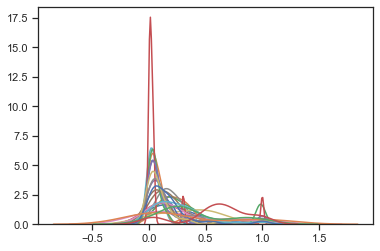

In [31]:
#([EYETRACKING_DATA_STD[cond(task, interface)]['Duration'].dropna()] for task in EYETRACKING_DATA_STD['Task name'].unique() for interface in EYETRACKING_DATA_STD['Testowany interfejs']])
args = [[EYETRACKING_DATA_STD[cond(*pair)]['Duration']] for pair in product(EYETRACKING_DATA_STD['Task name'].unique(), EYETRACKING_DATA_STD['Testowany interfejs'].unique())]
for arg in args:
    sns.distplot(arg, hist=False)
    

In [32]:
COGNITIVE_TESTS[['Kod badanego', 'CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej']]

,Kod badanego,CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej
0,2,5.0
1,13,4.0
2,12,6.0
3,10,7.0
4,16,4.0
5,4,7.0
6,6,6.0
7,11,NaN
8,7,5.0
9,15,5.0


In [33]:
h7_data = pd.merge(EYETRACKING_DATA_STD[['Kod badanego', 'Testowany interfejs', 'Duration', 'Number of errors']],
                   SUS_RECODED[['Kod badanego', 'Suma']], 
                   on="Kod badanego")
cond=lambda sub, interface :(SUS_RECODED['Kod badanego'] == sub) & (SUS_RECODED['Testowany interfejs'] == interface)
cond2=lambda sub, interface :(h7_data['Kod badanego'] == sub) & (h7_data['Testowany interfejs'] == interface)
h7_data_processed = pd.DataFrame(columns=['Kod badanego', 'Testowany interfejs', 'SUS', 'Sum of weighted time', 'Sum of errors', 'Sum of time'])
for sub in h7_data['Kod badanego'].unique():
    for interface in h7_data['Testowany interfejs'].unique():
        temp = pd.DataFrame([[sub, 
                              interface, 
                              SUS_RECODED[cond(sub, interface)]['Suma'].values[0], 
                              h7_data[cond2(sub,interface)]['Duration'].sum(), 
                              h7_data[cond2(sub,interface)]['Number of errors'].sum(),
                              EYETRACKING_DATA.where(EYETRACKING_DATA['Kod badanego'] == sub).where(EYETRACKING_DATA['Testowany interfejs'] == interface)['Duration'].sum()]],
                              columns=h7_data_processed.columns)
        h7_data_processed = pd.concat([h7_data_processed, temp])
h7_data_processed = h7_data_processed.where(h7_data_processed['Sum of weighted time'] > 0).dropna()
# droping subjects that had less than 3 tasks
EYETRACKING_SUMMARY= h7_data_processed.where(h7_data_processed['Kod badanego'] != 3).where(h7_data_processed['Kod badanego'] != 2).where(h7_data_processed['Kod badanego'] != 8).dropna()
for sub in EYETRACKING_SUMMARY['Kod badanego'].unique():
    if len(EYETRACKING_SUMMARY[EYETRACKING_SUMMARY['Kod badanego'] == sub]) != 3:
        print(f"misisng data at {sub}")
EYETRACKING_SUMMARY = pd.merge(EYETRACKING_SUMMARY,
                               COGNITIVE_TESTS[['Kod badanego', 
                                                'CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej',
                                               ]],
                              on="Kod badanego")

EYETRACKING_SUMMARY.columns = list(chain(EYETRACKING_SUMMARY.columns[:-1], ['CORSI']))
EYETRACKING_SUMMARY['Sum of errors'] = EYETRACKING_SUMMARY['Sum of errors'].values.astype(float)
EYETRACKING_SUMMARY['SUS'] = EYETRACKING_SUMMARY['SUS'].values.astype(int)
# EYETRACKING_SUMMARY

## Dane osobowe

In [34]:
if exists("./osobowe.csv"):
    PERSONAL_DATA = pd.read_csv("./osobowe.csv")
else:
    SPREADSHEET_ID = '1a6J_P-5dPknHRX5_s5oBQm79p-dz2XILF9EKsfX3AJQ'
    RANGE = 'osobowe!A1:G46' # name of sheet, and selected cells
    PERSONAL_DATA = hp.gsheet2df(hp.get_google_sheet(SPREADSHEET_ID, range=RANGE))
    PERSONAL_DATA.to_csv("./osobowe.csv")
ID = "Unnamed: 0"
PERSONAL_DATA = hp.code_to_numeric(PERSONAL_DATA)
# PERSONAL_DATA

# Weryfikacja hipotez

## Różnice pomiędzy interfejsami - SUS

In [35]:
# Normality check
pingouin.normality(dv="Suma",
                   group="Testowany interfejs",
                   data=SUS_RECODED)

,W,pval,normal
Przyciski wzrokowe,0.882867,0.052368,True
Obszary aktywowane spojrzeniem,0.927581,0.251007,True
Obszary aktywowane przemieszczeniem spojrzenia,0.891679,0.071101,True


In [36]:
# Repeated measures ANOVA documentation
# https://pingouin-stats.org/generated/pingouin.rm_anova.html#pingouin.rm_anova
print(pingouin.rm_anova(dv="Suma", 
                  within="Testowany interfejs",
                  subject="Kod badanego",
                  data=SUS_RECODED,
                  detailed=True))


                Source        SS  DF       MS       F        p-unc    np2  \
0  Testowany interfejs   784.933   2  392.467  10.791  0.000335578  0.435   
1                Error  1018.400  28   36.371       -            -      -   

     eps  
0  0.897  
1      -  


In [37]:
pingouin.pairwise.pairwise_ttests(dv="Suma", 
                                  within="Testowany interfejs",
                                  subject="Kod badanego",
                                  data=SUS_RECODED)

,Contrast,A,B,Paired,Parametric,T,dof,tail,p-unc,BF10,CLES,hedges
0,Testowany interfejs,Przyciski wzrokowe,Obszary aktywowane spojrzeniem,True,True,1.036,14.0,two-sided,0.317640,0.415,0.587,0.314
1,Testowany interfejs,Przyciski wzrokowe,Obszary aktywowane przemieszczeniem spojrzenia,True,True,4.440,14.0,two-sided,0.000560,63.795,0.782,1.183
2,Testowany interfejs,Obszary aktywowane spojrzeniem,Obszary aktywowane przemieszczeniem spojrzenia,True,True,3.074,14.0,two-sided,0.008245,6.53,0.756,0.960


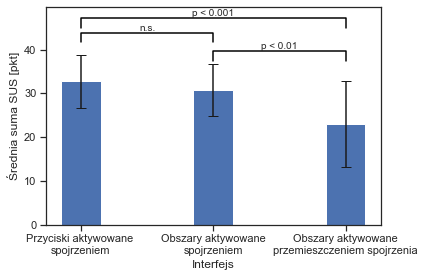

In [38]:
x = SUS_RECODED['Testowany interfejs'].unique()
y = np.array([ np.array(SUS_RECODED[SUS_RECODED['Testowany interfejs'] == a]['Suma'].mean()) for a in x])
yerr = np.array([SUS_RECODED[SUS_RECODED['Testowany interfejs'] == a]['Suma'].std() for a in x])
a = plt.bar(['Przyciski aktywowane \nspojrzeniem', 'Obszary aktywowane\nspojrzeniem', 'Obszary aktywowane\nprzemieszczeniem spojrzenia'], y, color='b', yerr=yerr, width=0.3, capsize=5)
plt.ylabel('Średnia suma SUS [pkt]')
plt.xlabel('Interfejs')
hp.barplot_annotate_brackets(0,1, 'n.s.', np.arange(len(y)), y+7)
hp.barplot_annotate_brackets(0,2, 'p < 0.001', np.arange(len(y)), y+10)
hp.barplot_annotate_brackets(1,2, 'p < 0.01', np.arange(len(y)), y+4)
plt.savefig('sus_plot.png', dpi=1000, paper='a4')
plt.show()

## Różnice pomiędzy interfejsami - czas

In [39]:
# Normality check
pingouin.normality(dv="Sum of time",
                   group="Testowany interfejs",
                   data=EYETRACKING_SUMMARY)

,W,pval,normal
Obszary aktywowane przemieszczeniem spojrzenia,0.957512,0.771951,True
Obszary aktywowane spojrzeniem,0.968032,0.877393,True
Przyciski wzrokowe,0.858431,0.092186,True


In [40]:
# Repeated measures ANOVA documentation
# https://pingouin-stats.org/generated/pingouin.rm_anova.html#pingouin.rm_anova
pingouin.rm_anova(dv="Sum of time", 
                  within="Testowany interfejs",
                  subject="Kod badanego",
                  data=EYETRACKING_SUMMARY,
                  detailed=True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,Testowany interfejs,1.325551e+11,2,6.627757e+10,11.591,0.000773273,0.592,0.655
1,Error,9.149126e+10,16,5.718203e+09,-,-,-,-


In [41]:
pingouin.pairwise.pairwise_ttests(dv="Sum of time", 
                                  within="Testowany interfejs",
                                  subject="Kod badanego",
                                  padjust="bonferroni",
                                  data=EYETRACKING_SUMMARY)

,Contrast,A,B,Paired,Parametric,T,dof,tail,p-unc,p-corr,p-adjust,BF10,CLES,hedges
0,Testowany interfejs,Obszary aktywowane przemieszczeniem spojrzenia,Obszary aktywowane spojrzeniem,True,True,3.279,8.0,two-sided,0.011197,0.033592,bonferroni,5.813,0.815,1.457
1,Testowany interfejs,Obszary aktywowane przemieszczeniem spojrzenia,Przyciski wzrokowe,True,True,3.821,8.0,two-sided,0.005085,0.015254,bonferroni,10.92,0.840,1.550
2,Testowany interfejs,Obszary aktywowane spojrzeniem,Przyciski wzrokowe,True,True,1.074,8.0,two-sided,0.314182,0.942546,bonferroni,0.51,0.617,0.354


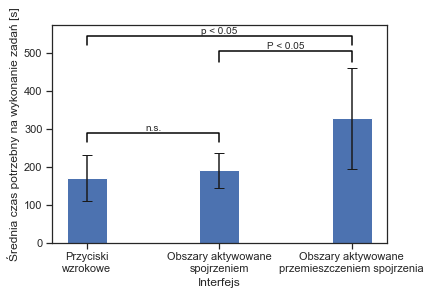

In [42]:
x = np.array(['Przyciski wzrokowe', 'Obszary aktywowane spojrzeniem', 'Obszary aktywowane przemieszczeniem spojrzenia'])
_x = np.array(['Przyciski\nwzrokowe', 'Obszary aktywowane\nspojrzeniem', 'Obszary aktywowane\nprzemieszczeniem spojrzenia'])
y = np.array([ np.array(EYETRACKING_SUMMARY[EYETRACKING_SUMMARY['Testowany interfejs'] == a]['Sum of time'].mean()) for a in x])/1000
yerr = np.array([EYETRACKING_SUMMARY[EYETRACKING_SUMMARY['Testowany interfejs'] == a]['Sum of time'].std() for a in x])/1000
a = plt.bar(_x, y, color='b', yerr=yerr, width=0.3, capsize=5)
plt.ylabel('Średnia czas potrzebny na wykonanie zadań [s]')
plt.xlabel('Interfejs')
hp.barplot_annotate_brackets(0,1, 'n.s.', np.arange(len(y)), y+50)
hp.barplot_annotate_brackets(0,2, 'p < 0.05', np.arange(len(y)), y+170)
hp.barplot_annotate_brackets(1,2, 'P < 0.05', np.arange(len(y)), y+120)
plt.savefig('time_plot.png', dpi=1000, paper='a4')
plt.show()

## Różnice pomiędzy interfejsami - błędy

In [43]:
# Normality check
pingouin.normality(dv="Sum of errors",
                   group="Testowany interfejs",
                   data=EYETRACKING_SUMMARY)

,W,pval,normal
Obszary aktywowane przemieszczeniem spojrzenia,0.886170,0.182153,True
Obszary aktywowane spojrzeniem,0.876994,0.145960,True
Przyciski wzrokowe,0.813416,0.029025,False


In [44]:
# Repeated measures ANOVA documentation
# https://pingouin-stats.org/generated/pingouin.rm_anova.html#pingouin.rm_anova
pingouin.friedman(dv="Sum of errors", 
                  within="Testowany interfejs",
                  subject="Kod badanego",
                  data=EYETRACKING_SUMMARY)

,Source,ddof1,Q,p-unc
Friedman,Testowany interfejs,2,1.647,0.43888


## Różnice w czasie wykonania poszczególnych zadań pomiędzy badanymi

In [45]:
# data = data[data['Kod badanego'].isin([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])]
for task in data['Task name'].unique():
    temp = data[data['Task name'] == task]
    print(task)
#     %R -i temp
#     %R library('ez')
#     %R result = ezANOVA(data=temp, dv=Duration, wid=Kod.badanego, within=Testowany.interfejs, within_full=Testowany.interfejs, detailed=TRUE, type=3)
#     %R print(result)
#     %R -i temp
#     %R library('ez')
#     %R result = ezDesign(data=temp, x=Duration, y=Kod.badanego, row=Testowany.interfejs)
#     %R print(result)

FeedForward
Rewind
IncreaseVolume
PauseAndResume
SetVideo
ReduceVolume
SetPanelAndVideo
Pause


Spore braki w danych i brak spójności bazy

## Hipoteza 1: różne osoby w zależności od temperamentu i inteligencji mogą preferować różne interfejsy aplikacji

Hipoteza związana z temperamentem jest nieweryfikowalna ze względu na braki w danych

In [46]:
h1_data = pd.merge(SUS_RECODED[['Kod badanego', 
                                'Testowany interfejs', 'Suma']], 
                   COGNITIVE_TESTS[['Kod badanego', 
                                    'APM/S1 RawScore - GW - Wartość surowa Total number of correct answers']], 
                   on="Kod badanego")
h1_data = h1_data.dropna()
h1_data.columns = chain(h1_data.columns[:-1], ['Raven'])
# h1_data

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



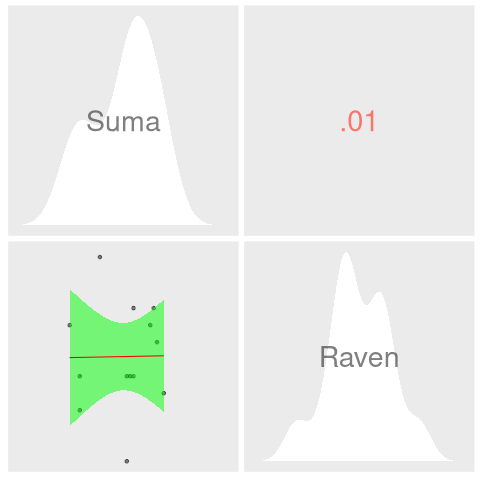

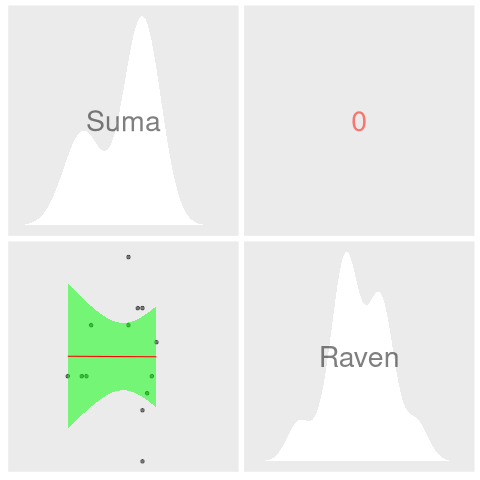

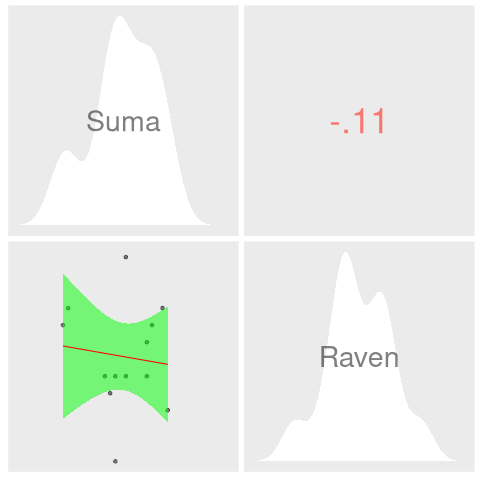

In [47]:
temp = h1_data[h1_data['Testowany interfejs'] == 'Obszary aktywowane przemieszczeniem spojrzenia'][['Suma', 'Raven']]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
temp = h1_data[h1_data['Testowany interfejs'] == 'Przyciski wzrokowe'][['Suma', 'Raven']]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
temp = h1_data[h1_data['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem'][['Suma', 'Raven']]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
pass

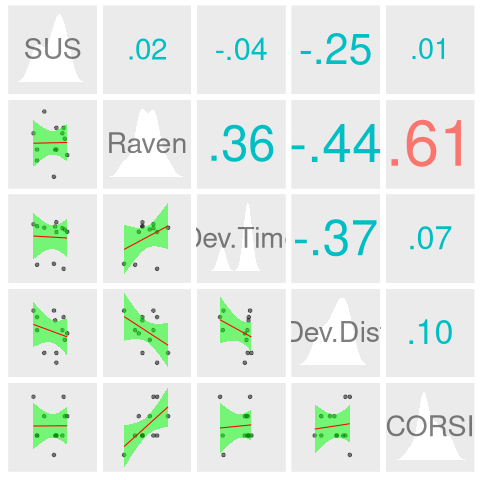

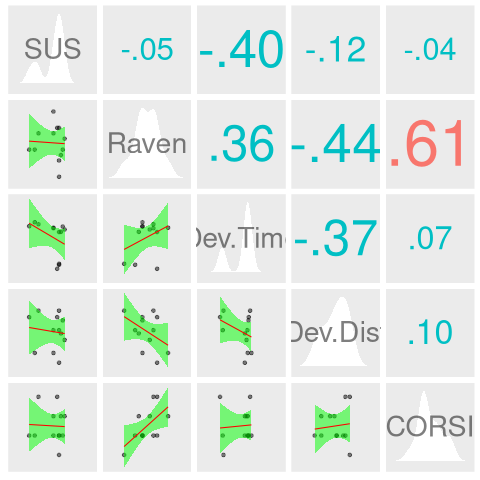

TypeError: 'NULLType' object is not iterable

R object with classes: ('gg', 'ggplot') mapped to:
[ListSexpV..., ListSexpV..., SexpEnvir..., ListSexpV..., ..., SexpEnvir..., SexpEnvir..., SexpEnvir..., ListSexpV...]
  data: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x7f38da356320> [RTYPES.VECSXP]
  layers: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x7f38da3568c0> [RTYPES.VECSXP]
  scales: <class 'rpy2.rinterface.SexpEnvironment'>
  <rpy2.rinterface.SexpEnvironment object at 0x7f38da356320> [RTYPES.ENVSXP]
  mapping: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x7f38da3568c0> [RTYPES.VECSXP]
  theme: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x7f38da35baf0> [RTYPES.VECSXP]
  coordinates: <class 'rpy2.rinterface.SexpEnvironment'>
  <rpy2.rinterface.SexpEnvironment object at 0x7f38da3568c0> [RTYPES.ENVSXP]
  facet: <class 'rpy2.rinterface.SexpEnvironment'>
  <rpy2.rin

In [48]:
# eksploracja
eksploracja = pd.merge(h1_data, 
                   COGNITIVE_TESTS[['Kod badanego', 
                                    'ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym',
                                    'ZBA/S3 RawScore - MEDDF4 - Wartość surowa Mediana odchylenia kierunku',
                                    'CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej']],
                    on='Kod badanego')
eksploracja[eksploracja.columns[0]]
columns = list(eksploracja.columns[2:])
for col in columns:
    eksploracja[col] = eksploracja[col].values.astype(float)
eksploracja = eksploracja.dropna()
eksploracja.columns = ['Kod badanego', 'Testowany interfejs', 'SUS', 'Raven', 'Dev Time', 'Dev Dist', 'CORSI']
eksploracja = eksploracja[eksploracja.columns[1:]]
temp = eksploracja[eksploracja['Testowany interfejs'] == 'Obszary aktywowane przemieszczeniem spojrzenia'][eksploracja.columns[1:]]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
temp = eksploracja[eksploracja['Testowany interfejs'] == 'Przyciski wzrokowe'][eksploracja.columns[1:]]
%R -i temp
%R library('ez')
%R dupa = ezCor(temp)
%R print(dupa)
temp = eksploracja[eksploracja['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem'][eksploracja.columns[1:]]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)


## Hipoteza obalona - nie ma istotnych korelacji między inteligencją, a oceną interfejsu w żadnej z 3 grup

## Hipoteza 2: osoby o większej rozpiętości pamięci lepiej będą radziły sobie z interfejsami wymagającymi zapamiętania lokalizacji

In [49]:
h3_data = EYETRACKING_SUMMARY[EYETRACKING_SUMMARY['Testowany interfejs'] != 'Przyciski wzrokowe']
%R -i h3_data
%R library('rmcorr')
%R corr = rmcorr(participant=Kod.badanego, measure1=Sum.of.time, measure2=CORSI, dataset=h3_data)
%R print(corr)
%R corr = rmcorr(participant=Kod.badanego, measure1=Sum.of.errors, measure2=CORSI, dataset=h3_data)
%R print(corr)


Repeated measures correlation

r
0.3912433

degrees of freedom
8

p-value
0.2635672

95% confidence interval
-0.4327337 0.8590715
Repeated measures correlation

r
0.9028306

degrees of freedom
8

p-value
0.0003463659

95% confidence interval
0.5446888 0.9824613

## Hipoteza obalona - rozpiętość pamięciowa nie ma wpływu na wyniki osiagane w poszczególnych interfejsach

## Hipoteza 3: osoby w lepszą zdolnością antycypacji czasowo-przestrzennej będą lepiej sobie radziły w interfejsie aktywowanym przemieszczeniem spojrzenia

In [50]:
h3_data = EYETRACKING_SUMMARY.where(EYETRACKING_SUMMARY['Testowany interfejs'] == 'Obszary aktywowane przemieszczeniem spojrzenia').dropna()
h3_data = pd.merge(h3_data[['Kod badanego', 'Sum of errors', 'Sum of time']],
                   COGNITIVE_TESTS[['Kod badanego',
                                    'ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym',
                                    'ZBA/S3 RawScore - MEDDF4 - Wartość surowa Mediana odchylenia kierunku']],
                   on='Kod badanego').dropna()
h3_data.columns = ['Kod badanego', 'Errors', 'Time', 'Dev Median Time', 'Dev Median Distance']
h3_data['Errors'] = h3_data['Errors'].astype(int)
# h3_data = h3_data[h3_data.columns[1:]]
pingouin.pairwise_corr(h3_data, columns=[['Dev Median Time', 'Dev Median Distance'], ['Errors', 'Time']], padjust='bonf', method='pearson', tail='one-sided')

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
0,Dev Median Time,Errors,pearson,one-sided,8,0.483,"[-0.34, 0.89]",0.233,-0.074,0.527,0.112834,0.451338,bonf,1.407,0.355
1,Dev Median Time,Time,pearson,one-sided,8,-0.469,"[-0.88, 0.35]",0.220,-0.092,-0.509,0.120462,0.481849,bonf,1.34,0.340
2,Dev Median Distance,Errors,pearson,one-sided,8,-0.516,"[-0.9, 0.3]",0.266,-0.027,-0.571,0.095342,0.381370,bonf,1.597,0.394
3,Dev Median Distance,Time,pearson,one-sided,8,-0.360,"[-0.85, 0.46]",0.130,-0.219,-0.377,0.190542,0.762170,bonf,0.945,0.234


## Hipoteza 4: lepsze zdolności wyobrażeniowe ułatwiają korzystanie z interfejsów wykorzystujących obszary wykraczające poza ekran,

## Hipoteza 5: korzystając z interfejsu obszarów aktywowanych spojrzeniem użytkownicy popełniają mniej błędów niż w interfejsie przycisków aktywowanych spojrzeniem

In [51]:
h5_data = pd.DataFrame.copy(EYETRACKING_SUMMARY)
print(pingouin.normality(data=h5_data, dv="Sum of errors", group="Testowany interfejs"))
x = h5_data[h5_data["Testowany interfejs"] == "Obszary aktywowane spojrzeniem"]['Sum of errors'].values
y = h5_data[h5_data["Testowany interfejs"] == "Przyciski wzrokowe"]['Sum of errors'].values
print(pingouin.ttest(x=x, 
                     y=y,
                     paired=True, tail='two-sided'))
print(h5_data[h5_data['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem']['Sum of errors'].mean(), '+-', h5_data[h5_data['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem']['Sum of errors'].std())
print(h5_data[h5_data['Testowany interfejs'] == 'Przyciski wzrokowe']['Sum of errors'].mean(), '+-', h5_data[h5_data['Testowany interfejs'] == 'Przyciski wzrokowe']['Sum of errors'].std())

                                                       W      pval  normal
Obszary aktywowane przemieszczeniem spojrzenia  0.886170  0.182153    True
Obszary aktywowane spojrzeniem                  0.876994  0.145960    True
Przyciski wzrokowe                              0.813416  0.029025   False
           T  dof       tail    p-val           CI95%  cohen-d   BF10  power
T-test -1.58    8  two-sided  0.15271  [-44.27, 8.27]    0.288  0.814  0.119
64.0 +- 49.658836071740545
82.0 +- 75.28446054797763


## Hipoteza obalona - nie ma istotnych różnic w ilości popełnionych błędów pomiędzy pzyciskami wzrokowymi i obszarami aktywowanymi spojrzeniem. Jednakże średnia ilość błędów popełnionych podczas korzystania z obszarów aktywowanych spojrzeniem jest mniejsza.

## Hipoteza 6: obszary aktywowane przemieszczeniem spojrzenia ze względu na niższy próg czasowy niezbędny do aktywowania charakteryzuje się krótszym czasem wykonania zadań w porównaniu do obszarów aktywowanych spojrzeniem

In [52]:
h6_data = EYETRACKING_SUMMARY[['Kod badanego', 'Testowany interfejs', 'Sum of time']]
h6_data = h6_data.where(h6_data['Testowany interfejs'] != 'Przyciski wzrokowe').dropna()
# h6_data

                                                       W      pval  normal
Obszary aktywowane przemieszczeniem spojrzenia  0.957512  0.771951    True
Obszary aktywowane spojrzeniem                  0.968032  0.877393    True
Nie zostały zachowany warunke normalności rozkładu zmiennej zależnej
            T  dof       tail     p-val                   CI95%  cohen-d  \
T-test -3.279    8  two-sided  0.011197  [-234313.9, -40836.09]     1.53   

         BF10  power  
T-test  5.813  0.979  
Istotne różnice pomiędzy grupami
Obszary aktywowane spojrzeniem: 190.41486523333327  +- 47.161289074759544
Obszary aktywowane przemieszczeniem spojrzenia: 327.98985971111114  +- 132.70396163426457


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


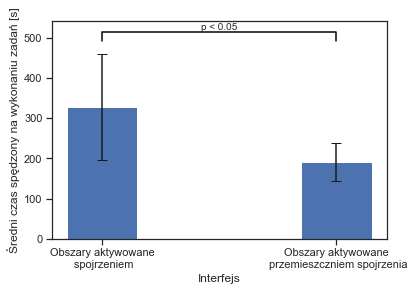

In [53]:
print(pingouin.normality(dv="Sum of time", group="Testowany interfejs", data=h6_data))
print("Nie zostały zachowany warunke normalności rozkładu zmiennej zależnej")
x = h6_data[h5_data["Testowany interfejs"] == "Obszary aktywowane spojrzeniem"]['Sum of time']
y = h6_data[h5_data["Testowany interfejs"] == "Obszary aktywowane przemieszczeniem spojrzenia"]['Sum of time']
print(pingouin.ttest(x=x, 
                     y=y,
                     paired=True, tail='two-sided'))
print("Istotne różnice pomiędzy grupami")
print("Obszary aktywowane spojrzeniem:", x.mean()/1000, " +-", x.std()/1000)
print("Obszary aktywowane przemieszczeniem spojrzenia:", y.mean()/1000, " +-", y.std()/1000)

x = h6_data['Testowany interfejs'].unique()
y = np.array([ np.array(h6_data[h6_data['Testowany interfejs'] == a]['Sum of time'].mean()/1000) for a in x])
yerr = np.array([ h6_data[h6_data['Testowany interfejs'] == a]['Sum of time'].std()/1000 for a in x])
a = plt.bar(['Obszary aktywowane\n spojrzeniem', 'Obszary aktywowane\n przemieszczniem spojrzenia'], y, color='b', yerr=yerr, width=0.3, capsize=5)
plt.ylabel('Średni czas spędzony na wykonaniu zadań [s]')
plt.xlabel('Interfejs')
hp.barplot_annotate_brackets(0,1, 'p < 0.05', np.arange(len(y)), y+140)
# hp.barplot_annotate_brackets(0,2, 'p < 0.01', np.arange(len(y)), y+200)
# hp.barplot_annotate_brackets(1,2, 'p < 0.01', np.arange(len(y)), y+120)
plt.savefig('time_spent.png', dpi=1000, paper='a4', bbox_inches='tight')
plt.show()


## Istotne różnice pomiędzy obszarami sterowanymi przemieszczeniem spojrzenia i pozostałymi

## Hipoteza 7: na ocenę interfejsu ma wpływ ilość popełnionych błędów podczas korzystania i czas przeznaczony na poszczególne zadania

             r  dof      pval           CI95%  power
rm_corr -0.793   17  0.000051  [-0.92, -0.53]  0.993
             r  dof      pval          CI95%  power
rm_corr  0.101   17  0.682061  [-0.37, 0.53]  0.069


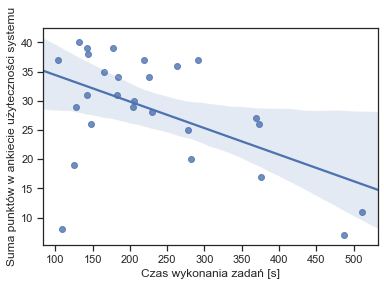

,r,dof,pval,CI95%,power
rm_corr,0.147,17,0.548976,"[-0.33, 0.56]",0.092


In [54]:
h7_data = EYETRACKING_SUMMARY
h7_data = h7_data[h7_data['Sum of time'] > 0]
x = h7_data['Sum of time']
y = h7_data['SUS']
print(pingouin.rm_corr(data=h7_data, x="SUS", y="Sum of time", subject="Kod badanego"))
print(pingouin.rm_corr(data=h7_data, x="SUS", y="Sum of errors", subject="Kod badanego"))

x = np.array(h7_data['Sum of time'].values, dtype=np.float)
y = np.array(h7_data['SUS'].values, dtype=np.int)

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
h7_data['Sum of time'] = h7_data['Sum of time']/1000
#plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
sns.regplot(x="Sum of time", y="SUS", data=h7_data);
plt.xlabel('Czas wykonania zadań [s]')
plt.ylabel('Suma punktów w ankiecie użyteczności systemu')
plt.savefig('regression.png', dpi=1000, paper='a4')
plt.show()
pingouin.rm_corr(data=h7_data, x="Sum of time", y="Sum of errors", subject="Kod badanego")

## Istotne statystycznie korelacja pomiędzy ilościa spędzonego czasu, a oceną intefejsu

## Zdarzenia Eyetrackerowe

In [181]:
from functools import reduce
data_list = []

for file in glob("./eyetracking_events/dwell-time_buttons/*"):
    data_list.append(pd.read_csv(file, skiprows=[0], header=[0], delimiter=";"))
    
dwell_time_buttons_df = reduce(lambda x,y: x.append(y, ignore_index=True), data_list)

data_list = []

for file in glob("./eyetracking_events/dwell-time_regions/*"):
    data_list.append(pd.read_csv(file, skiprows=[0], header=[0], delimiter=";"))
    
dwell_time_regions_df = reduce(lambda x,y: x.append(y, ignore_index=True), data_list)

data_list = []

for file in glob("./eyetracking_events/enter-and-leave_regions/*"):
    data_list.append(pd.read_csv(file, skiprows=[0], header=[0], delimiter=";"))
    
enter_and_leave_regions_df = reduce(lambda x,y: x.append(y, ignore_index=True), data_list)

# adding extra column
dwell_time_buttons_df['Testowany interfejs'] = 'Przyciski aktywowane spojrzeniem'
dwell_time_regions_df['Testowany interfejs'] = 'Obszary aktywowane spojrzeniem'
enter_and_leave_regions_df['Testowany interfejs'] = 'Obszary aktywowane przemieszczeniem spojrzenia'

events_df = dwell_time_buttons_df.append(dwell_time_regions_df, ignore_index=True)
events_df = events_df.append(enter_and_leave_regions_df, ignore_index=True)
events_df

,#EndPosition,EndRecordIndex,EndTimeMiliseconds,EyeLaterality,GazeState,MaximalAcceleration,MaximalSpeed,MinimalAcceleration,MinimalSpeed,PositionAveraged,PositionDisplacement,PositionPathLength,PositionVariance,StartPosition,StartRecordIndex,StartTimeMiliseconds,Unnamed: 16,Testowany interfejs
0,"(1061.06, 738.65)",5,939739.068,Right,Saccade,647.073460914902,1294.70621968847,0.490655,2.19365,"(852.751, 589.358)",10.672493,2597.377947,415.249016,"(1071.01, 734.79)",1,939719.063,NaN,Przyciski aktywowane spojrzeniem
1,"(1088.49, 762.53)",5,939739.068,Left,Saccade,166.300505173959,332.737781058142,0.0897052,0.577702,"(817.74125, 572.50375)",4.103291,2667.601688,499.559759,"(1090.2, 766.26)",2,939723.064,NaN,Przyciski aktywowane spojrzeniem
2,"(1094.25, 759.25)",23,939811.084,Left,Fixation,0.305733377780532,1.06923161662945,0.0281109,0.0825172,"(1087.89444444444, 760.706111111111)",6.628424,33.018932,4.250947,"(1088.49, 762.53)",6,939739.068,NaN,Przyciski aktywowane spojrzeniem
3,"(1074.06, 736.04)",22,939807.083,Right,Fixation,1.60213066825821,5.53479900267385,0.159843,1.08074,"(1070.37588235294, 732.377941176471)",13.259416,49.769574,8.421260,"(1061.06, 738.65)",6,939739.068,NaN,Przyciski aktywowane spojrzeniem
4,"(812.05, 711.07)",48,939910.263,Right,Saccade,610.627652704073,1292.50828546667,0.588669,1.02489,"(664.422572727273, 562.391531818182)",263.197152,13362.392563,NaN,"(1074.06, 736.04)",23,939807.083,NaN,Przyciski aktywowane spojrzeniem
5,"(837.98, 736.53)",48,939910.263,Left,Saccade,154.257905372672,331.179178617092,0.0876731,0.39084,"(653.980555555556, 569.527916666667)",257.275167,13705.946580,NaN,"(1094.25, 759.25)",24,939811.084,NaN,Przyciski aktywowane spojrzeniem
6,"(840.46, 723.61)",67,939984.878,Left,Fixation,0.16389309294131,0.672100086058845,0.00393782,0.0407436,"(839.026315789474, 732.55)",13.155866,23.227077,4.162643,"(837.98, 736.53)",49,939910.263,NaN,Przyciski aktywowane spojrzeniem
7,"(812.12, 695.2)",66,939980.951,Right,Fixation,0.898601985689035,4.57983624161394,0.161956,0.718471,"(816.805833333333, 700.870277777778)",15.870154,31.083919,6.421845,"(812.05, 711.07)",49,939910.263,NaN,Przyciski aktywowane spojrzeniem
8,"(812.37, 697.48)",91,940079.129,Right,Saccade,544.424801678974,1069.79411500531,0.131088,0.460435,"(612.9238, 525.295325)",2.293665,12770.715492,NaN,"(812.12, 695.2)",67,939980.951,NaN,Przyciski aktywowane spojrzeniem
9,"(827.65, 727.71)",91,940079.129,Left,Saccade,143.611962032684,282.329175534663,0.0530068,0.119247,"(623.214791666667, 542.763333333333)",13.450134,13241.603538,NaN,"(840.46, 723.61)",68,939984.878,NaN,Przyciski aktywowane spojrzeniem


In [270]:
events_df = events_df[['GazeState', 'EndTimeMiliseconds', 'StartTimeMiliseconds', 'Testowany interfejs', 'EyeLaterality', 'PositionDisplacement']]
events_df = events_df.where(events_df['EyeLaterality'] == 'Right').dropna(how='all')
events_df

,GazeState,EndTimeMiliseconds,StartTimeMiliseconds,Testowany interfejs,EyeLaterality,PositionDisplacement
0,Saccade,939739.068,939719.063,Przyciski aktywowane spojrzeniem,Right,10.672493
3,Fixation,939807.083,939739.068,Przyciski aktywowane spojrzeniem,Right,13.259416
4,Saccade,939910.263,939807.083,Przyciski aktywowane spojrzeniem,Right,263.197152
7,Fixation,939980.951,939910.263,Przyciski aktywowane spojrzeniem,Right,15.870154
8,Saccade,940079.129,939980.951,Przyciski aktywowane spojrzeniem,Right,2.293665
11,Fixation,940130.763,940079.129,Przyciski aktywowane spojrzeniem,Right,12.695865
12,Saccade,940234.813,940130.763,Przyciski aktywowane spojrzeniem,Right,207.031836
14,Fixation,940302.887,940234.813,Przyciski aktywowane spojrzeniem,Right,12.336491
16,Saccade,940575.107,940302.887,Przyciski aktywowane spojrzeniem,Right,74.474705
21,Fixation,940634.403,940575.107,Przyciski aktywowane spojrzeniem,Right,16.221480


In [282]:
_sum= events_df.shape[0]
print("Global")
print(f"Saccade {events_df[events_df['GazeState'] == 'Saccade'].dropna().shape[0]*100/_sum}")
print(f"Fixation {events_df[events_df['GazeState'] == 'Fixation'].dropna().shape[0]*100/_sum}")
print(f"Blink {events_df[events_df['GazeState'] == 'Blink'].dropna().shape[0]*100/_sum}")
for interfejs in events_df['Testowany interfejs'].unique():
    df = events_df.where(events_df['Testowany interfejs'] == interfejs).dropna()
    _sum = df.shape[0]
    print('\n',interfejs)
    print(f"Saccade {df[df['GazeState'] == 'Saccade'].dropna().shape[0]*100/_sum}")
    print(f"Fixation {df[df['GazeState'] == 'Fixation'].dropna().shape[0]*100/_sum}")
    print(f"Blink {df[df['GazeState'] == 'Blink'].dropna().shape[0]*100/_sum}")

Global
Saccade 49.008498583569406
Fixation 48.80034487005789
Blink 0.1539598472718315

 Przyciski aktywowane spojrzeniem
Saccade 49.89834446703456
Fixation 49.86930002904444
Blink 0.23235550392099913

 Obszary aktywowane spojrzeniem
Saccade 50.03445582762898
Fixation 49.823126751504574
Blink 0.1424174208664492

 Obszary aktywowane przemieszczeniem spojrzenia
Saccade 50.09565896903883
Fixation 49.780388564037615
Blink 0.12395246692355366


## Delatas

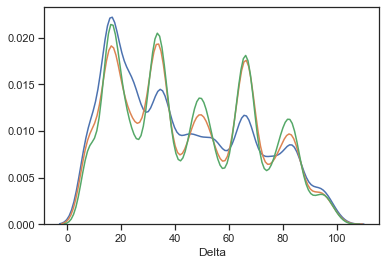

In [168]:
events_df['Delta'] = events_df['EndTimeMiliseconds'] - events_df['StartTimeMiliseconds']
deltas_df = events_df[events_df['Delta'] < 100]
for interfejs in deltas_df['Testowany interfejs'].unique():
    sns.distplot(deltas_df[deltas_df['Testowany interfejs'] == interfejs]['Delta'], hist=False)

In [284]:
for interfejs in deltas_df['Testowany interfejs'].unique():
    for state in deltas_df['GazeState'].unique():
        print(f"{interfejs}:{state}:median {deltas_df.where(deltas_df['Testowany interfejs'] == interfejs).where(deltas_df['GazeState'] == state)['Delta'].median()}")
        # print(f"{interfejs}:{state}:mean {deltas_df.where(deltas_df['Testowany interfejs'] == interfejs).where(deltas_df['GazeState'] == state)['Delta'].mean()}")
        #print(f"{interfejs}:{state}:std {deltas_df.where(deltas_df['Testowany interfejs'] == interfejs).where(deltas_df['GazeState'] == state)['Delta'].std()}")

Przyciski aktywowane spojrzeniem:Saccade:median 40.15549999999348
Przyciski aktywowane spojrzeniem:Fixation:median 33.379000000073574
Przyciski aktywowane spojrzeniem:Blink:median 59.184999999939464
Obszary aktywowane spojrzeniem:Saccade:median 53.20999999996275
Obszary aktywowane spojrzeniem:Fixation:median 33.39199999999255
Obszary aktywowane spojrzeniem:Blink:median 79.99350000009872
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:median 48.032999999821186
Obszary aktywowane przemieszczeniem spojrzenia:Fixation:median 35.42200000002049
Obszary aktywowane przemieszczeniem spojrzenia:Blink:median 72.64550000007148


In [231]:
for interfejs in deltas_df['Testowany interfejs'].unique():
    print(pingouin.normality(data=deltas_df[deltas_df['Testowany interfejs'] == interfejs], dv='Delta', group=('GazeState')))

                 W      pval  normal
Saccade   0.911660  0.000000   False
Fixation  0.924431  0.000000   False
Blink     0.944914  0.000763   False
                 W      pval  normal
Saccade   0.929366  0.000000   False
Fixation  0.936659  0.000000   False
Blink     0.901561  0.000072   False
                 W      pval  normal
Saccade   0.929458  0.000000   False
Fixation  0.942510  0.000000   False
Blink     0.960331  0.004246   False


In [235]:
for state in deltas_df['GazeState'].unique():
    for left, right in combinations(deltas_df['Testowany interfejs'].unique(), r=2):
        x=deltas_df.where(deltas_df['Testowany interfejs'] == left).where(deltas_df['GazeState'] == state)['Delta'].dropna(how='all') 
        y=deltas_df.where(deltas_df['Testowany interfejs'] == right).where(deltas_df['GazeState'] == state)['Delta'].dropna(how='all')
        print(f"{left} {right} {state}")
        %R -i x -i y
        %R result = ks.test(x=x, y=y)  
        %R print(result)
        pass

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.1153, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.10043, p-value < 2.2e-16
alternative hypothesis: two-sided

Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.041846, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.076384, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.10662, p-value < 2.2e-16
alternative hypothesis: two-sid

## Position displacement

In [175]:
position_df = events_df[events_df['PositionDisplacement'] < 500]
for interfejs in position_df['Testowany interfejs'].unique():
    sns.distplot(position_df[position_df['Testowany interfejs'] == interfejs]['PositionDisplacement'], hist=False)

In [178]:
for interfejs in position_df['Testowany interfejs'].unique():
    for state in position_df['GazeState'].unique():
        print(f"{interfejs}:{state}:median {position_df.where(position_df['Testowany interfejs'] == interfejs).where(position_df['GazeState'] == state)['PositionDisplacement'].median()}")
        print(f"{interfejs}:{state}:mean {position_df.where(position_df['Testowany interfejs'] == interfejs).where(position_df['GazeState'] == state)['PositionDisplacement'].mean()}")
        #print(f"{interfejs}:{state}:std {position_df.where(position_df['Testowany interfejs'] == interfejs).where(position_df['GazeState'] == state)['PositionDisplacement'].std()}")

Przyciski aktywowane spojrzeniem:Saccade:median 10.903302252070198
Przyciski aktywowane spojrzeniem:Saccade:mean 35.60132227723785
Przyciski aktywowane spojrzeniem:Saccade:std 76.24121839392564
Przyciski aktywowane spojrzeniem:Fixation:median 10.5076781450519
Przyciski aktywowane spojrzeniem:Fixation:mean 14.52687497417881
Przyciski aktywowane spojrzeniem:Fixation:std 14.954463049492338
Obszary aktywowane spojrzeniem:Saccade:median 11.789560895947098
Obszary aktywowane spojrzeniem:Saccade:mean 36.43152726624707
Obszary aktywowane spojrzeniem:Saccade:std 77.4098925912519
Obszary aktywowane spojrzeniem:Fixation:median 10.4314045024514
Obszary aktywowane spojrzeniem:Fixation:mean 14.635516035199103
Obszary aktywowane spojrzeniem:Fixation:std 15.087682742966052
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:median 11.093833838643501
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:mean 35.21166417758786
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:std 75.75075092257

In [236]:
for interfejs in position_df['Testowany interfejs'].unique():
    print(pingouin.normality(data=position_df[position_df['Testowany interfejs'] == interfejs], dv='PositionDisplacement', group=('GazeState')))

                 W  pval  normal
Saccade   0.448919   0.0   False
Fixation  0.696491   0.0   False
                 W  pval  normal
Saccade   0.445302   0.0   False
Fixation  0.704883   0.0   False
                 W  pval  normal
Saccade   0.441725   0.0   False
Fixation  0.739515   0.0   False


/usr/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [239]:
for state in position_df['GazeState'].unique():
    for left, right in combinations(position_df['Testowany interfejs'].unique(), r=2):
        x=position_df.where(position_df['Testowany interfejs'] == left).where(position_df['GazeState'] == state)['PositionDisplacement'].dropna(how='all') 
        y=position_df.where(position_df['Testowany interfejs'] == right).where(position_df['GazeState'] == state)['PositionDisplacement'].dropna(how='all')
        print(f"{left} {right} {state}")
        %R -i x -i y
        %R result = ks.test(x=x, y=y)  
        %R print(result)
        pass

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.035896, p-value = 2.548e-10
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.011953, p-value = 0.08571
alternative hypothesis: two-sided

Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.024794, p-value = 7.485e-07
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.0075054, p-value = 0.6704
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.010259, p-value = 0.1763
alternative hypothesis: 

## Speed

/home/siegfriedwagner/.local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/siegfriedwagner/.local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


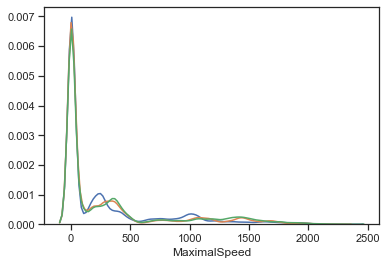

In [190]:
speed_df = events_df.copy() #[events_df['MaximalSpeed'] < 500]
speed_df['MaximalSpeed'] = speed_df['MaximalSpeed'].dropna()
for interfejs in speed_df['Testowany interfejs'].unique():
    sns.distplot(speed_df[speed_df['Testowany interfejs'] == interfejs]['MaximalSpeed'], hist=False)

In [286]:
for interfejs in speed_df['Testowany interfejs'].unique():
    for state in speed_df['GazeState'].unique():
        print(f"{interfejs}:{state}:median {speed_df.where(speed_df['Testowany interfejs'] == interfejs).where(speed_df['GazeState'] == state)['MaximalSpeed'].median()}")
        #print(f"{interfejs}:{state}:mean {speed_df.where(speed_df['Testowany interfejs'] == interfejs).where(speed_df['GazeState'] == state)['MaximalSpeed'].mean()}")
        #print(f"{interfejs}:{state}:std {speed_df.where(speed_df['Testowany interfejs'] == interfejs).where(speed_df['GazeState'] == state)['MaximalSpeed'].std()}")

Przyciski aktywowane spojrzeniem:Saccade:median 331.80071556511297
Przyciski aktywowane spojrzeniem:Fixation:median 2.911147632653015
Przyciski aktywowane spojrzeniem:Blink:median -inf
Obszary aktywowane spojrzeniem:Saccade:median 354.185387811982
Obszary aktywowane spojrzeniem:Fixation:median 2.55453997159178
Obszary aktywowane spojrzeniem:Blink:median -inf
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:median 387.494836795288
Obszary aktywowane przemieszczeniem spojrzenia:Fixation:median 2.3622333893278604
Obszary aktywowane przemieszczeniem spojrzenia:Blink:median -inf


In [240]:
for interfejs in speed_df['Testowany interfejs'].unique():
    print(pingouin.normality(data=speed_df[speed_df['Testowany interfejs'] == interfejs], dv='MaximalSpeed', group=('GazeState')))

In [241]:
for state in speed_df['GazeState'].unique():
    for left, right in combinations(speed_df['Testowany interfejs'].unique(), r=2):
        x=speed_df.where(speed_df['Testowany interfejs'] == left).where(speed_df['GazeState'] == state)['MaximalSpeed'].dropna(how='all') 
        y=speed_df.where(speed_df['Testowany interfejs'] == right).where(speed_df['GazeState'] == state)['MaximalSpeed'].dropna(how='all')
        print(f"{left} {right} {state}")
        %R -i x -i y
        %R result = ks.test(x=x, y=y)  
        %R print(result)
        pass

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.064559, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.1272, p-value < 2.2e-16
alternative hypothesis: two-sided

Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.084799, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.047065, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.081057, p-value < 2.2e-16
alternative hypothesis: two-s

## Acceleration

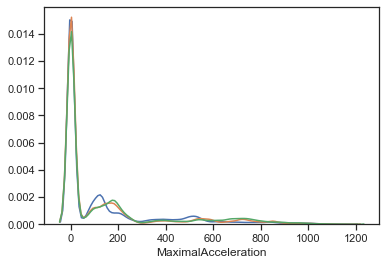

In [249]:
acceleration_df = events_df.copy() #[events_df['MaximalSpeed'] < 500]
acceleration_df['MaximalAcceleration'] = acceleration_df['MaximalAcceleration'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
for interfejs in acceleration_df['Testowany interfejs'].unique():
    sns.distplot(acceleration_df[acceleration_df['Testowany interfejs'] == interfejs]['MaximalAcceleration'], hist=False)

In [287]:
for interfejs in acceleration_df['Testowany interfejs'].unique():
    for state in acceleration_df['GazeState'].unique():
        print(f"{interfejs}:{state}:median {acceleration_df.where(acceleration_df['Testowany interfejs'] == interfejs).where(acceleration_df['GazeState'] == state)['MaximalAcceleration'].median()}")
        # print(f"{interfejs}:{state}:mean {acceleration_df.where(acceleration_df['Testowany interfejs'] == interfejs).where(acceleration_df['GazeState'] == state)['MaximalAcceleration'].mean()}")
        #print(f"{interfejs}:{state}:std {acceleration_df.where(acceleration_df['Testowany interfejs'] == interfejs).where(acceleration_df['GazeState'] == state)['MaximalAcceleration'].std()}")

Przyciski aktywowane spojrzeniem:Saccade:median 151.254272073376
Przyciski aktywowane spojrzeniem:Fixation:median 0.632447001892288


/usr/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Przyciski aktywowane spojrzeniem:Blink:median nan
Obszary aktywowane spojrzeniem:Saccade:median 167.692871986066
Obszary aktywowane spojrzeniem:Fixation:median 0.560042140137993
Obszary aktywowane spojrzeniem:Blink:median nan
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:median 187.639386088583
Obszary aktywowane przemieszczeniem spojrzenia:Fixation:median 0.565941179735865
Obszary aktywowane przemieszczeniem spojrzenia:Blink:median nan


In [253]:
for interfejs in acceleration_df['Testowany interfejs'].unique():
    try:
        print(pingouin.normality(data=acceleration_df[acceleration_df['Testowany interfejs'] == interfejs], dv='MaximalAcceleration', group=('GazeState')))
    except ValueError:
        pass

In [256]:
for state in acceleration_df['GazeState'].unique():
    for left, right in combinations(acceleration_df['Testowany interfejs'].unique(), r=2):
        x=acceleration_df.where(acceleration_df['Testowany interfejs'] == left).where(acceleration_df['GazeState'] == state)['MaximalAcceleration'].dropna(how='all') 
        y=acceleration_df.where(acceleration_df['Testowany interfejs'] == right).where(acceleration_df['GazeState'] == state)['MaximalAcceleration'].dropna(how='all')
        print(f"{left} {right} {state}")
        %R -i x -i y
        %R result = ks.test(x=x, y=y)  
        %R print(result)
        pass

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.054605, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.13069, p-value < 2.2e-16
alternative hypothesis: two-sided

Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.089976, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.057417, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.050131, p-value < 2.2e-16
alternative hypothesis: two-

R[write to console]: Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

R[write to console]: In addition: 
R[write to console]: There were 36 warnings (use warnings() to see them)
R[write to console]: 



Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Blink

Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.027724, p-value = 7.822e-11
alternative hypothesis: two-sided



R[write to console]: Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test



Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Blink

Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.027724, p-value = 7.822e-11
alternative hypothesis: two-sided



R[write to console]: Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test



Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Blink

Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.027724, p-value = 7.822e-11
alternative hypothesis: two-sided



## PositionPathLength

/home/siegfriedwagner/.local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/siegfriedwagner/.local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


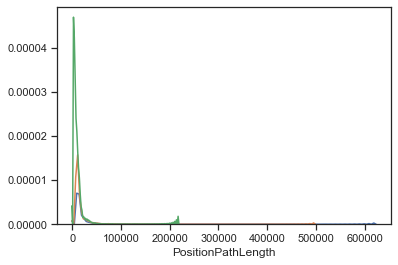

In [259]:
lenght_df = events_df.copy() #[events_df['MaximalSpeed'] < 500]
# lenght_df['MaximalAcceleration'] = lenght_df['MaximalAcceleration'].astype(float)
for interfejs in lenght_df['Testowany interfejs'].unique():
    sns.distplot(lenght_df[lenght_df['Testowany interfejs'] == interfejs]['PositionPathLength'], hist=False)

In [288]:
for interfejs in lenght_df['Testowany interfejs'].unique():
    for state in lenght_df['GazeState'].unique():
        print(f"{interfejs}:{state}:median {lenght_df.where(lenght_df['Testowany interfejs'] == interfejs).where(lenght_df['GazeState'] == state)['PositionPathLength'].median()}")
        # print(f"{interfejs}:{state}:mean {lenght_df.where(lenght_df['Testowany interfejs'] == interfejs).where(lenght_df['GazeState'] == state)['PositionPathLength'].mean()}")
        #print(f"{interfejs}:{state}:std {lenght_df.where(lenght_df['Testowany interfejs'] == interfejs).where(lenght_df['GazeState'] == state)['PositionPathLength'].std()}")

Przyciski aktywowane spojrzeniem:Saccade:median 3543.87346315419
Przyciski aktywowane spojrzeniem:Fixation:median 29.69845436007595
Przyciski aktywowane spojrzeniem:Blink:median nan
Obszary aktywowane spojrzeniem:Saccade:median 3820.4817450082396
Obszary aktywowane spojrzeniem:Fixation:median 26.9292686479086
Obszary aktywowane spojrzeniem:Blink:median nan
Obszary aktywowane przemieszczeniem spojrzenia:Saccade:median 4912.07455074571
Obszary aktywowane przemieszczeniem spojrzenia:Fixation:median 26.032629456503052
Obszary aktywowane przemieszczeniem spojrzenia:Blink:median nan


In [261]:
for interfejs in lenght_df['Testowany interfejs'].unique():
    print(pingouin.normality(data=lenght_df[lenght_df['Testowany interfejs'] == interfejs], dv='PositionPathLength', group=('GazeState')))

ValueError: Data must be at least length 3.

In [262]:
for state in lenght_df['GazeState'].unique():
    for left, right in combinations(lenght_df['Testowany interfejs'].unique(), r=2):
        x=lenght_df.where(lenght_df['Testowany interfejs'] == left).where(lenght_df['GazeState'] == state)['PositionPathLength'].dropna(how='all') 
        y=lenght_df.where(lenght_df['Testowany interfejs'] == right).where(lenght_df['GazeState'] == state)['PositionPathLength'].dropna(how='all')
        print(f"{left} {right} {state}")
        %R -i x -i y
        %R result = ks.test(x=x, y=y)  
        %R print(result)
        pass

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.070169, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.14307, p-value < 2.2e-16
alternative hypothesis: two-sided

Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Saccade

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.081203, p-value < 2.2e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.039346, p-value = 3.331e-16
alternative hypothesis: two-sided

Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Fixation

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.089302, p-value < 2.2e-16
alternative hypothesis: tw

R[write to console]: Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test



Przyciski aktywowane spojrzeniem Obszary aktywowane spojrzeniem Blink

Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.052058, p-value < 2.2e-16
alternative hypothesis: two-sided



R[write to console]: Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test



Przyciski aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Blink

Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.052058, p-value < 2.2e-16
alternative hypothesis: two-sided



R[write to console]: Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test



Obszary aktywowane spojrzeniem Obszary aktywowane przemieszczeniem spojrzenia Blink

Error in ks.test(x = x, y = y) : not enough 'x' data
Calls: <Anonymous> -> <Anonymous> -> withVisible -> ks.test

	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.052058, p-value < 2.2e-16
alternative hypothesis: two-sided

